In [1]:
from enum import Enum
from pathlib import Path
import sys
sys.path.append('../')
sys.path.append('../../../model')

from metrics import *
from losses import flatten_model
from data import EMPSSR
from custom_transforms import RandomCutOut, GaussianBlur, ToGrayScale
from utils import show_sample, show_result, get_pssr_transforms, find_lr
from model import DynamicUnet

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# training param
gpu_id = 3
sample = True
pretrained = True
config = {'y_channel': 3, 'x_channel': 3}

In [3]:
# SPECS
num_cores = 4
torch.cuda.set_device(gpu_id)
train_set = pd.read_csv('../train.csv')
valid_set = pd.read_csv('../valid.csv')
arch = models.resnet34(pretrained)
encoder = nn.Sequential(*list(arch.children())[:-2])
nt = Enum('NormType', 'Batch BatchZero Weight Spectral')
model_kind = 'baseline/'
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/')

In [4]:
size = 512  # image size
model = DynamicUnet(encoder, n_classes=config['y_channel'],
                    img_size=(size,size), norm_type=nt.Weight)

In [5]:
tfms = get_pssr_transforms(size)
train_ds = EMPSSR(train_set, tfms)
valid_ds = EMPSSR(valid_set, tfms)

In [7]:
model_name = '4.30_round_3'
save_pth = model_pth/model_kind/(model_name+'.pkl')
model.load_state_dict(torch.load(save_pth))

<All keys matched successfully>

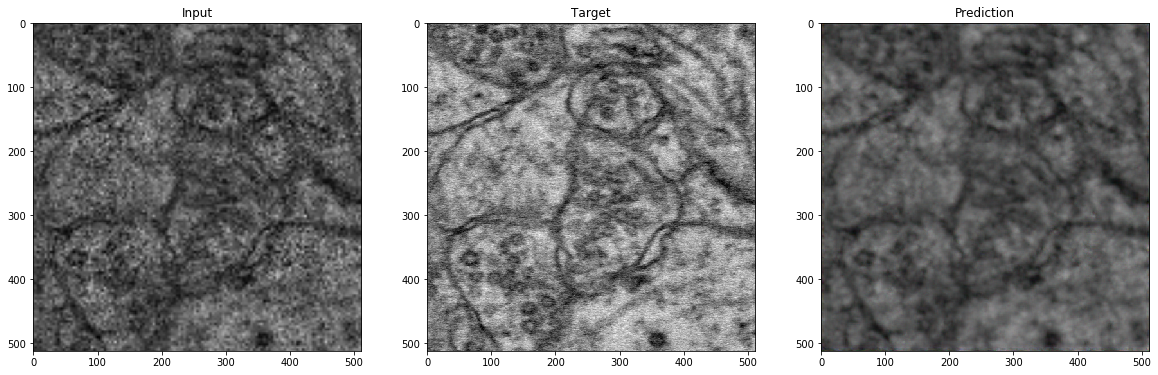

In [9]:
x, y = valid_ds[0]
x, y = x.cuda(), y.cuda()
model.eval()
model.cuda()
pred = model(x.unsqueeze(0))
show_result(x, y, pred)